## FluxInfer

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict, OrderedDict
import pathlib

import numpy as np
import pandas as pd
import torch
import torchinfo
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

import sys
sys.path.append("../")

In [5]:
from notebooklib.save import run_tsdr, save_tsdr, load_tsdr

DATASET_ID = "qknmc"
datasets_fluxrank_max_cluster = load_tsdr(DATASET_ID, suffix="fluxrank_max_cluster", revert_normalized_time_series=True)

In [54]:
from itertools import combinations

import networkx as nx

import diagnoser.metric_node as mn
from diagnoser import diag

def fisher_z(dm, cm, x, y) -> float:
    m = dm.shape[0]
    r = cm[x, y]
    if 1 - r == 0. or 1 + r == 0.:
        r = 1 - 1e-10
    zstat = np.sqrt(m - 3) * 0.5 * np.log((1 + r) / (1 - r))
    p_val = 2.0 * scipy.stats.norm.sf(np.absolute(zstat))
    return p_val

def build_wudg(pk, data_df: pd.DataFrame, init_graph_type="complete") -> nx.Graph:
    nodes = mn.MetricNodes.from_dataframe(data_df)
    g: nx.Graph
    match init_graph_type:
        case "complete":
            g = nx.Graph()
            for (u, v) in combinations(nodes, 2):
                g.add_edge(u, v)
        case "nw_call":
            g = diag.prepare_init_graph(nodes, pk)
        case _:
            assert False, f"Unknown init_graph_type: {init_graph_type}"

    dm = data_df.to_numpy()
    cm = np.corrcoef(dm.T)
    _g = nx.relabel_nodes(g, mapping=nodes.node_to_num)
    for (u, v) in _g.edges:
        p_val = fisher_z(dm, cm, u, v)
        _g[u][v]['weight'] = 1 / p_val if p_val != 0.0 else sys.float_info.max

    return nx.relabel_nodes(_g, mapping=nodes.num_to_node)

In [55]:
import joblib

from meltria import loader

wudgs: list[tuple[nx.Graph, loader.DatasetRecord, pd.DataFrame, pd.DataFrame]]
wudgs = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg)(record.pk, reduced_df, init_graph_type="nw_call") for record, _, _, reduced_df in datasets_fluxrank_max_cluster)

/tmp/ipykernel_1079400/1585241563.py:35: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_1079400/1585241563.py:35: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_1079400/1585241563.py:35: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_1079400/1585241563.py:35: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_1079400/1585241563.py:35: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_1079400/1585241563.py:35: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_1079400/1585241563.py:35: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_1079400/1585241563.py:35: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_1079400/1585241563.py:35: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_1079400/1585241563.py:35: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_1079400/1585241563.py:35:

In [56]:
prs: list[tuple[dict, loader.DatasetRecord, pd.DataFrame, pd.DataFrame]] = []
prs = joblib.Parallel(n_jobs=-1)(joblib.delayed(nx.pagerank)(wudg, alpha=0.85) for wudg in wudgs)

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,


In [72]:
_records = []
for pr, (record, _, _, _) in zip(prs, datasets_fluxrank_max_cluster):
    for metric_name, rank in pr.items():
        _records.append((DATASET_ID, record.target_app(), record.chaos_type(), record.chaos_comp(), str(metric_name), record.data_df[str(metric_name)].values, rank))

ranked_df = pd.DataFrame(_records, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric", "time_series", "rank"])
sorted_results_df = ranked_df.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(sorted_results_df.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

metric  \
dataset_id target_app chaos_type       chaos_comp                                                                                     
qknmc      sock-shop  pod-network-loss user-db                                                         c-user-db_memory_usage_bytes   
                                       user-db                                                   c-user-db_memory_working_set_bytes   
                                       user-db                                                   c-carts-db_cpu_usage_seconds_total   
                                       user-db                                            m-front-end_process_resident_memory_bytes   
                                       user-db                                             m-front-end_nodejs_heap_size_total_bytes   
                                       user-db                                                    c-carts-db_cpu_user_seconds_total   
                                       user-db                                                      c-carts_cpu_usage_seconds_total   
                                       user-db                                                       c-user_cpu_usage_seconds_total   
                                       user-db                                                               s-catalogue_throughput   
                                       user-db                                                       c-carts_cpu_user_seconds_total   
                                       user                                                              c-payment_file_descriptors   
                                       user                                                                       c-payment_sockets   
                                       user                                                          c-user_cpu_usage_seconds_total   
                                       user                                                        c-orders_cpu_usage_seconds_total   
                                       user                                                       c-payment_cpu_usage_seconds_total   
                                       user                                                  c-catalogue-db_cpu_usage_seconds_total   
                                       user                                                         c-payment_cpu_cfs_periods_total   
                                       user                                                           c-user_cpu_user_seconds_total   
                                       user                                                         c-orders_cpu_user_seconds_total   
                                       user                                                   c-catalogue-db_cpu_user_seconds_total   
                                       payment                                                                    c-payment_sockets   
                                       payment                                                           c-payment_file_descriptors   
                                       payment                                                   c-carts-db_cpu_usage_seconds_total   
                                       payment                                                    c-carts-db_cpu_user_seconds_total   
                                       payment                                        m-carts-db_mongodb_sys_disks_sda_io_queued_ms   
                                       payment                                       m-carts-db_mongodb_sys_disks_sda_write_time_ms   
                                       payment                                                   m-carts-db_mongodb_sys_cpu_idle_ms   
                                       payment                                                  m-orders-db_mongodb_sys_cpu_idle_ms   
                                       payment                             

In [58]:
from itertools import chain

from pandas.core.groupby import DataFrameGroupBy

from eval.groundtruth import check_cause_metrics
from diagnoser.metric_node import MetricNodes
from meltria.priorknowledge.priorknowledge import SockShopKnowledge

from meltria.priorknowledge.priorknowledge import SockShopKnowledge
from diagnoser.metric_node import MetricNodes, MetricNode

pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewalres": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

EXCLUDED_CAUSE_METRICS: list[str] = [
    "go_memstats"
]

def get_ranks_by_case(sorted_results_df: DataFrameGroupBy, pk: SockShopKnowledge, granularity: str = "metric"):
    ranks_by_case: dict[str, dict[str, list[int]]] = defaultdict(lambda: defaultdict(list))
    n_cases: int = 0
    for (dataset_id, target_app, chaos_type, chaos_comp), group in sorted_results_df:
        if chaos_comp == "queue-master":
            continue
        metrics = [
            str(m) for m in group["metric"].values.tolist()
            if not any([em in str(m) for em in EXCLUDED_CAUSE_METRICS])
        ]
        ranks: list[int]
        match granularity:
            case "metric":
                ok, cause_metrics = check_cause_metrics(
                    pk, metrics, chaos_type=chaos_type, chaos_comp=chaos_comp, optional_cause=True,
                )
                if not ok or len(cause_metrics) == 0:
                    print(f"no cause metrics: {dataset_id}, {target_app}, {chaos_type}, {chaos_comp}")
                    continue
                ranked_metrics = MetricNodes.from_metric_names(metrics)
                ranks = sorted([list(ranked_metrics).index(cm) + 1 for cm in cause_metrics])
            case "container":
                ranked_ctnrs = dict.fromkeys([pk.get_container_by_metric(metric) for metric in metrics])
                ranks = sorted([i+1 for i, ctnr in enumerate(ranked_ctnrs) if ctnr == chaos_comp])
            case "service":
                chaos_service: str = pk.get_service_by_container(chaos_comp)
                ranked_service = dict.fromkeys([pk.get_service_by_metric(metric) for metric in metrics])
                ranked_service = [s for s in ranked_service if s is not None and not s.startswith("gke-")]
                ranks = sorted([i+1 for i, service in enumerate(ranked_service) if service == chaos_service])
            case _:
                assert False, f"Unknown detect_unit: {granularity}"
        ranks_by_case[chaos_type][chaos_comp] = ranks
        n_cases += 1
    return ranks_by_case, n_cases


def calc_ac_k(k: int, ranks_by_case: dict[str, dict[str, list[int]]], n_faults: int) -> float:
    ac_a: list[float] = []
    sum_ac = 0.0
    for chaos_type, ranks_by_ in ranks_by_case.items():
        for chaos_comp, ranks in ranks_by_.items():
            if (min_param := min(k, len(ranks)) > 0):
                sum_ac += sum([1 if ranks[i-1] <= k else 0 for i in range(1, min_param+1)]) / min_param
    return sum_ac / n_faults


def evaluate_ac_of_rc(
    sorted_results_df: DataFrameGroupBy, pk: SockShopKnowledge, k: int = 10, granuallity: str = "metric",
) -> pd.DataFrame:
    top_k_set = range(1, k+1)
    ranks_by_case, n_cases = get_ranks_by_case(sorted_results_df, pk, granularity=granuallity)
    ac_k = {k: calc_ac_k(k, ranks_by_case, n_cases) for k in top_k_set}
    avg_k = {k: sum([ac_k[j] for j in range(1, k+1)]) / k for k in top_k_set}
    return pd.concat([pd.DataFrame(ac_k, index=[f"AC@K ({granuallity})"]).T, pd.DataFrame(avg_k, index=[f"AVG@K ({granuallity})"]).T], axis=1)


In [60]:
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="service"),
        ], axis=1)
    )

no cause metrics: qknmc, sock-shop, pod-cpu-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-memory-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, carts-db
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue-db
no cause metrics: qknmc, sock-shop, pod-network-loss, orders
no cause metrics: qknmc, sock-shop, pod-network-loss, orders-db
no cause metrics: qknmc, sock-shop, pod-network-loss, user-db


,AC@K (metric),AVG@K (metric),AC@K (container),AVG@K (container),AC@K (service),AVG@K (service)
1,0.14,0.14,0.28,0.28,0.45,0.45
2,0.24,0.19,0.52,0.40,0.62,0.53
3,0.29,0.22,0.55,0.45,0.69,0.59
4,0.29,0.24,0.55,0.47,0.72,0.62
5,0.29,0.25,0.59,0.50,0.90,0.68
6,0.29,0.25,0.59,0.51,0.93,0.72
7,0.29,0.26,0.66,0.53,1.00,0.76
8,0.33,0.27,0.79,0.56,1.00,0.79
9,0.33,0.28,0.86,0.60,1.00,0.81
10,0.33,0.28,0.86,0.62,1.00,0.83


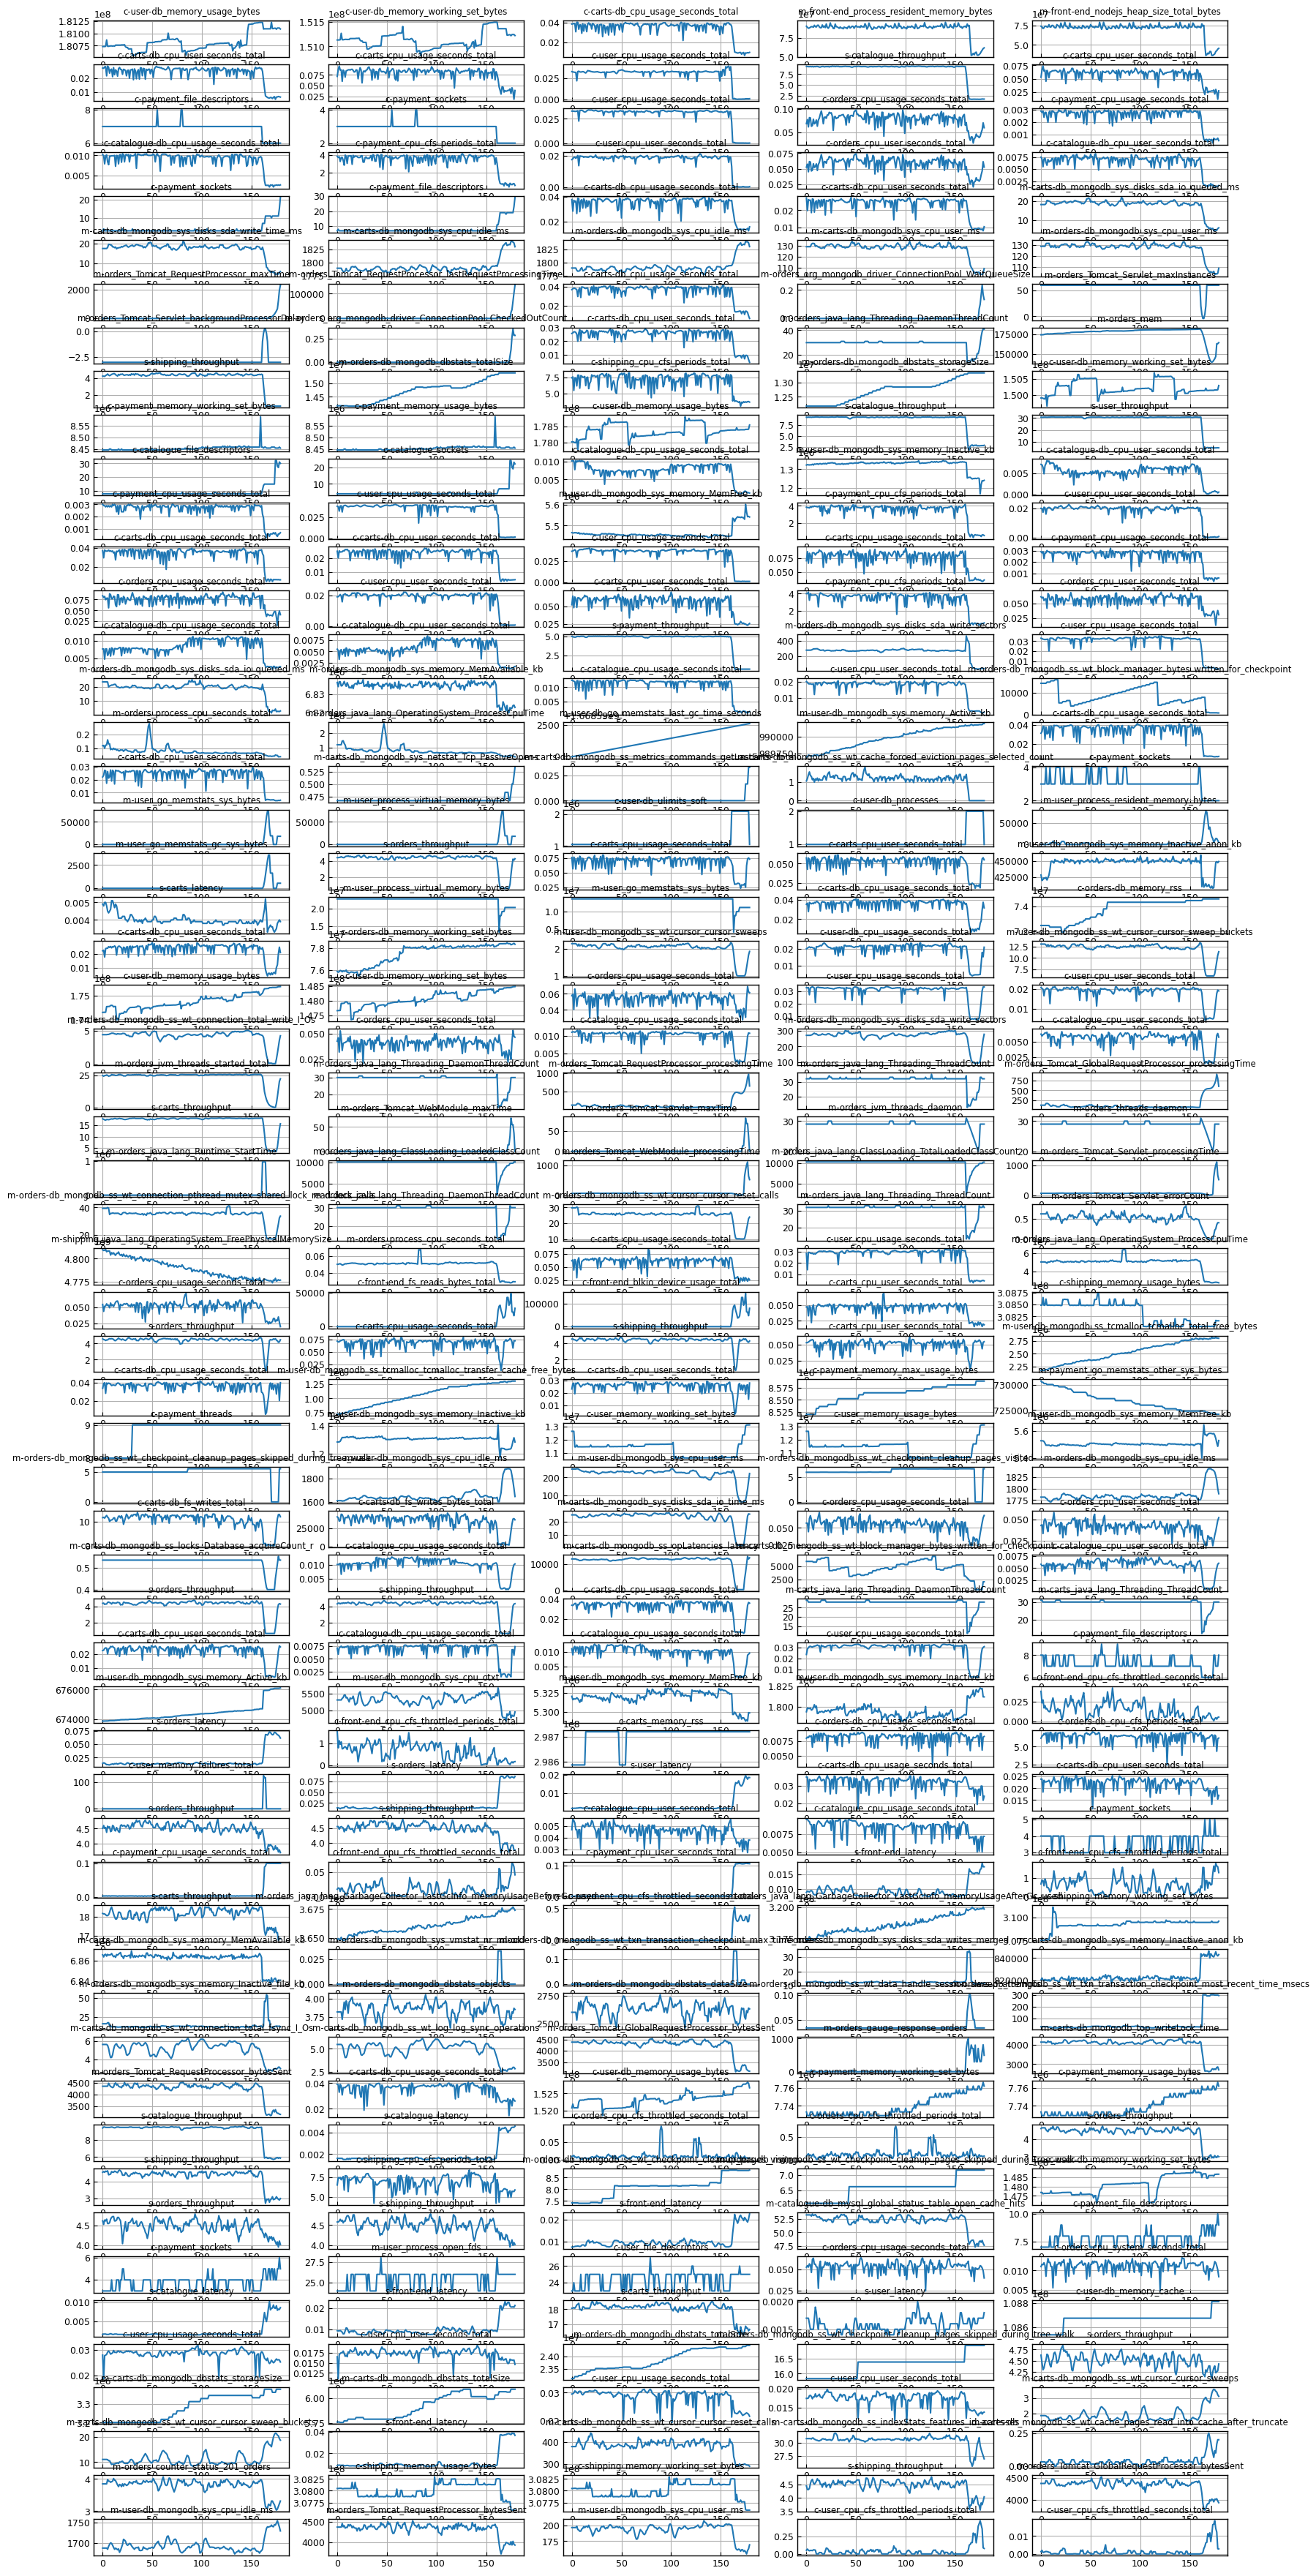

In [75]:
import math

_sorted_results_df = ranked_df.query("not metric.str.startswith('n-')", engine='python').sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"]).head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"])

fig = plt.figure(figsize=(20, 45))
axs = fig.subplots(nrows=math.ceil(_sorted_results_df.shape[0] / 5), ncols=5)
for ax, row in zip(axs.flatten(), _sorted_results_df.itertuples()):
    ax.plot(row.time_series)
    ax.set_title(row.metric)

## 3-Phase reduction

In [96]:
from tsdr import tsdr

def _hier_clustering(pk, data_df: pd.DataFrame, dist_type="sbd"):
    _, clustering_info = tsdr.Tsdr("residual_integral", **{
        "step2_clustering_method_name": "hierarchy",
        "step2_hierarchy_dist_threshold": 0.02,  # should be <1.0 if 'sbd' is specified
        "step2_hierarchy_dist_type": dist_type,  # 'pearsonr' or 'sbd'
        "step2_hierarchy_linkage_method": "single",  # 'single','complete','average','weighted', 'centroid', 'median', 'ward'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": 'medoid',  # 'medoid' or 'maxsum'
    }).reduce_multivariate_series(data_df.apply(scipy.stats.zscore), pk, n_workers=1)
    return data_df[list(clustering_info.keys())]

def _hdbscan_clustering(pk, data_df: pd.DataFrame, dist_type="sbd"):
    _, clustering_info = tsdr.Tsdr("residual_integral", **{
        "step2_clustering_method_name": "dbscan",
        "step2_dbscan_min_pts": 1,
        "step2_dbscan_dist_type": dist_type,  # 'pearsonr' or 'sbd'
        "step2_dbscan_algorithm": "hdbscan",  # 'dbscan' or 'hdbscan'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": 'medoid',  # 'medoid' or 'maxsum'
    }).reduce_multivariate_series(data_df.apply(scipy.stats.zscore), pk, n_workers=1)
    return data_df[list(clustering_info.keys())]

In [98]:
datasets_fluxrank_max_cluster_with_3phase = []
for record, filtered_df, anomalous_df, reduced_df in datasets_fluxrank_max_cluster:
    _df = _hier_clustering(record.pk, reduced_df)
    datasets_fluxrank_max_cluster_with_3phase.append((record, filtered_df, anomalous_df, reduced_df, _df))

In [ ]:
for record, filtered_df, anomalous_df, reduced_df, more_reduced_df in datasets_fluxrank_max_cluster_with_3phase:
    # _df = _hier_clustering(record.pk, reduced_df)
    if record.chaos_type() == "pod-cpu-hog" and record.chaos_comp() in ["user"]:
        print(reduced_df.columns)

Index(['c-carts_memory_failures_total',
       'c-carts-db_cpu_cfs_throttled_seconds_total',
       'c-carts-db_cpu_cfs_throttled_periods_total', 'c-catalogue_sockets',
       'c-catalogue_file_descriptors',
       'c-catalogue-db_cpu_cfs_throttled_seconds_total',
       'c-front-end_file_descriptors', 'c-front-end_sockets',
       'c-orders_sockets', 'c-orders_file_descriptors',
       ...
       'm-orders_gauge_response_orders', 'm-orders_counter_status_201_orders',
       'm-orders_Tomcat_WebResourceRoot_hitCount',
       'm-shipping_process_resident_memory_bytes',
       'm-user_go_memstats_frees_total', 'm-user_go_memstats_lookups_total',
       'm-user_process_cpu_seconds_total',
       'm-user_go_memstats_alloc_bytes_total',
       'm-user_go_memstats_mallocs_total',
       'm-user_microservices_demo_user_request_count'],
      dtype='object', length=155)
Index(['c-carts_cpu_cfs_periods_total', 'c-catalogue_cpu_usage_seconds_total',
       'c-carts-db_fs_reads_bytes_total', 'c-c

In [99]:
def build_wudg_and_pagerank(record, reduced_df, init_graph_type="nw_call"):
    wudg = build_wudg(record.pk, reduced_df, init_graph_type=init_graph_type)
    pr = nx.pagerank(wudg, alpha=0.85)
    _records = []
    for metric_name, rank in pr.items():
        _records.append((DATASET_ID, record.target_app(), record.chaos_type(), record.chaos_comp(), str(metric_name), record.data_df[str(metric_name)].values, rank))
    return _records

_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg_and_pagerank)(record, reduced_df, init_graph_type="nw_call") for record, _, _, _, reduced_df in datasets_fluxrank_max_cluster_with_3phase)
ranked_datasets_with_3phase = sum(_list_of_records, [])  # flatten

/tmp/ipykernel_1079400/1585241563.py:35: RuntimeWarning: overflow encountered in double_scalars
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/tmp/ipykernel_1079400/1585241563.py:35: RuntimeWarning: overflow encountered in double_scalars
/home/ub

In [100]:
ranked_df = pd.DataFrame(ranked_datasets_with_3phase, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric", "time_series", "rank"])
sorted_results_df_with_3phase = ranked_df.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(sorted_results_df_with_3phase.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

metric  \
dataset_id target_app chaos_type       chaos_comp                                                                                                            
qknmc      sock-shop  pod-network-loss user-db                                                                                c-user-db_memory_usage_bytes   
                                       user-db                                                                          c-user-db_memory_working_set_bytes   
                                       user-db                                                      m-shipping_java_lang_Threading_TotalStartedThreadCount   
                                       user-db                                m-carts-db_mongodb_ss_wt_cache_pages_written_requiring_in_memory_restoration   
                                       user-db                                                                          c-carts-db_cpu_usage_seconds_total   
                                       user-db                                                            m-shipping_java_lang_Threading_DaemonThreadCount   
                                       user-db                          m-carts-db_mongodb_ss_wt_cache_forced_eviction_pages_evicted_that_were_dirty_count   
                                       user-db                                                                         c-carts-db_cpu_system_seconds_total   
                                       user-db                                                                          m-orders_process_cpu_seconds_total   
                                       user-db                                                                           c-orders_cpu_system_seconds_total   
                                       user                                                                                                 c-user_threads   
                                       user                                                                                 m-orders_gauge_response_orders   
                                       user                                                                                              c-payment_sockets   
                                       user                                                                                      m-orders_process_open_fds   
                                       user                                                                           c-catalogue-db_cpu_cfs_periods_total   
                                       user                                                                               c-orders_cpu_usage_seconds_total   
                                       user                                                                          c-catalogue-db_cpu_user_seconds_total   
                                       user                                                                                   c-user-db_memory_usage_bytes   
                                       user                                                                                     c-carts_memory_usage_bytes   
                                       user                                                m-user-db_mongodb_ss_tcmalloc_tcmalloc_pageheap_committed_bytes   
                                       payment                                                                         c-front-end_cpu_usage_seconds_total   
                                       payment                                                                                          s-carts_throughput   
                                       payment                                                                           c-front-end_cpu_cfs_periods_total   
                                       payment                                                                           c-carts-db_cpu_user_seconds_total   
                                       p

In [101]:
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(sorted_results_df_with_3phase, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(sorted_results_df_with_3phase, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(sorted_results_df_with_3phase, pk, k=10, granuallity="service"),
        ], axis=1)
    )

no cause metrics: qknmc, sock-shop, pod-cpu-hog, carts
no cause metrics: qknmc, sock-shop, pod-cpu-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-cpu-hog, user
no cause metrics: qknmc, sock-shop, pod-memory-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, carts
no cause metrics: qknmc, sock-shop, pod-network-loss, carts-db
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue-db
no cause metrics: qknmc, sock-shop, pod-network-loss, orders
no cause metrics: qknmc, sock-shop, pod-network-loss, orders-db
no cause metrics: qknmc, sock-shop, pod-network-loss, user-db


,AC@K (metric),AVG@K (metric),AC@K (container),AVG@K (container),AC@K (service),AVG@K (service)
1,0.06,0.06,0.28,0.28,0.41,0.41
2,0.22,0.14,0.41,0.34,0.66,0.53
3,0.22,0.17,0.48,0.39,0.69,0.59
4,0.28,0.19,0.52,0.42,0.83,0.65
5,0.28,0.21,0.62,0.46,0.90,0.70
6,0.28,0.22,0.66,0.49,0.97,0.74
7,0.28,0.23,0.69,0.52,1.00,0.78
8,0.33,0.24,0.72,0.55,1.00,0.81
9,0.39,0.26,0.72,0.57,1.00,0.83
10,0.50,0.28,0.76,0.59,1.00,0.84
